In [188]:
import numpy as np
import h5py,time, matplotlib.pyplot as plt
from scipy.optimize import fmin_cg, minimize
from drift.core import manager
import corrcal2
import sys
sys.path.insert(0,'/home/zahra/PIPELINE')
from hirax_transfer import core
from log_red_cal_new import Visibilities_grid, Bls_counts, colour_scatterplot, Scatterplot, index_find
from decimal import Decimal
from operator import add,sub
import scipy as sp
from cora.util import hputil
from astropy.stats import gaussian_fwhm_to_sigma
from hirax_transfer.beams import separations
import healpy as hp
from cora.core import skysim
from cora.foreground import gaussianfg, galaxy
from cora.util import coord
from drift.core import visibility
sys.path.insert(0,'/home/zahra/hirax_tools/')
from hirax_tools import array_config

In [189]:
#m=manager.ProductManager.from_config('/home/zahra/PIPELINE/5by5_dishvar_pt1_kl/prod_params_custom.yaml')

#m=manager.ProductManager.from_config('/media/zahra/DATA/5by5_dishvar_pt01/prod_params_custom.yaml')
m=manager.ProductManager.from_config('/home/zahra/PIPELINE/example_5by5_kl_nodishscatter_lmax_200/prod_params_custom.yaml')


correlation_arr, _, _, arranged_corr_unique_bls_lengths, _ = Bls_counts(m)

t=m.telescope
Nfeeds,_=t.feedpositions.shape
Ndish=Nfeeds/2
Nbls=Ndish*(Ndish-1)/2
antspos = t.feedpositions[:Ndish]
x=t.feedpositions[:,0] #these are x and y positions not x and y polarizations
y=t.feedpositions[:,1]


Product directory: /home/zahra/PIPELINE/example_5by5_kl_nodishscatter_lmax_200/bt_matrices


In [190]:
runs=100
time_channel=400
sigma = 0.001
sky = 1.
dish_fluc = 5.

In [191]:
src=np.zeros(2*Nbls)
#src=src.reshape([1,2*Nbls]) 

In [192]:
lmax = t.lmax
mmax = t.mmax
nside = 128
print nside
angpos = hputil.ang_positions(nside)
zenith = t.zenith #same as np.radians(120)
frequencies = t.frequencies
print zenith
print angpos

128
[2.0943951 0.       ]
[[0.00637889 0.78539816]
 [0.00637889 2.35619449]
 [0.00637889 3.92699082]
 ...
 [3.13521376 2.35619449]
 [3.13521376 3.92699082]
 [3.13521376 5.49778714]]


In [193]:
wavelength = (3.e8)/(frequencies[0]*10.**6)
fwhm = 1.*wavelength/6.
sigma_beam = gaussian_fwhm_to_sigma*fwhm
seps = separations(angpos, zenith)
beammodel = np.exp(-seps**2/2/sigma_beam**2)
print beammodel

[0.00000000e+000 0.00000000e+000 0.00000000e+000 ... 1.21457520e-192
 1.21457520e-192 2.30466285e-189]


In [194]:
sph_arr = coord.sph_to_cart(angpos)
uhatc, vhatc = visibility.uv_plane_cart(zenith)


In [195]:
HAC = array_config.HIRAXArrayConfig.from_n_elem_compact(Ndish, 6.)


#uv = np.resize(np.repeat(3, sph_arr.shape[0]),(3, )
#print uv.shape

vis_all = np.array([])
#fringes_all = np.array([])

for i in correlation_arr:
    dish_0, dish_1 = i
    bl_ind = [np.int(dish_0), np.int(dish_1)]
    #v_coord, u_coord, _ = HAC.uvw_coords(frequencies[0],bl_ind)
    u_coord = (x[bl_ind[0]] - x[bl_ind[1]])/wavelength
    v_coord = (y[bl_ind[0]] - y[bl_ind[1]])/wavelength
    uv = u_coord * uhatc + v_coord * vhatc
    #print np.inner(sph_arr[0], uv), 'print '
    #print np.exp(np.inner(sph_arr[0], uv)), 'exp'
    fringes_ind = np.exp(1j*2*np.pi*np.sum(np.inner(np.abs(sph_arr), np.abs(uv))))
    vis_ind = np.sum(beammodel**2*fringes_ind*sky)
    vis_all = np.append(vis_all, vis_ind)
    #fringes_all = np.append(fringes_all, fringes_ind)

In [196]:
vis_ = vis_all

vis_new = np.zeros(300, dtype= 'complex')
vis_new[:188] += vis_[:188]

vis_new[188:196] += vis_[188:196]
vis_new[196:204] += vis_[204:212]
vis_new[204:212] += vis_[196:204]
vis_new[212:220] += vis_[212:220]

vis_new[220:226] += vis_[220:226]
vis_new[226:232] += vis_[232:238]
vis_new[232:238] += vis_[226:232]
vis_new[238:244] += vis_[238:244]

vis_new[244:254] += vis_[244:254]

vis_new[254:258] += vis_[254:258]
vis_new[258:262] += vis_[262:266]
vis_new[262:266] += vis_[258:262]
vis_new[266:270] += vis_[266:270]

vis_new[270:274] += vis_[270:274]
vis_new[274:278] += vis_[274:278]

vis_new[278:281] += vis_[278:281]
vis_new[281:284] += vis_[284:287]
vis_new[284:287] += vis_[281:284]
vis_new[287:290] += vis_[287:290]

vis_new[290:292] += vis_[290:292]
vis_new[292:294] += vis_[294:296]
vis_new[294:296] += vis_[292:294]
vis_new[296:298] += vis_[296:298]

vis_new[298:299] += vis_[298:299]
vis_new[299:300] += vis_[299:300]


In [197]:
arranged_corr_counts = np.load('arranged_corr_counts_5by5_24_red_blocks.npy')
lims = np.append(0, np.cumsum(arranged_corr_counts))

arranged_corr_unique_bls = np.load('arranged_corr_unique_bls_5by5_24_red_blocks.npy')
correlation_arr = np.load('corr_arr_5by5_24_red_blocks.npy')

In [198]:
vis_newer_real = np.zeros(300)
vis_newer_imag = np.zeros(300)

for i in range(len(lims)-1):
    vis_newer_real[lims[i]:lims[i+1]] += np.random.normal(vis_new.real[lims[i]], dish_fluc, arranged_corr_counts[i])
    vis_newer_imag[lims[i]:lims[i+1]] += np.random.normal(vis_new.imag[lims[i]], dish_fluc, arranged_corr_counts[i])
    

In [199]:
vis_newer = np.array([])
for element in range(300):
    vis_newer = np.append(vis_newer,complex(vis_newer_real[element], vis_newer_imag[element]))

In [200]:
ant1=correlation_arr[:,0].astype(int)
ant2=correlation_arr[:,1].astype(int)


In [201]:
vis_newer[:20]

array([-13.05404045-62.43731819j, -32.1064117 -63.1994721j ,
       -15.10108999-46.45678952j, -20.06898121-54.16987728j,
       -14.09458729-60.83812007j, -18.10044913-47.54905465j,
       -16.70842824-53.49450821j, -25.14545728-61.96175646j,
       -19.36301316-57.94124277j, -22.57665299-60.79052999j,
       -21.21255919-62.07020644j, -23.30444277-53.14896345j,
       -11.42306865-58.92258312j, -22.34802708-65.54883138j,
       -18.93964639-54.49186262j, -23.36680463-53.90390663j,
       -15.42125839-48.61097932j, -17.5642149 -56.38055152j,
       -23.10625183-55.22599604j, -12.11348293-57.63846039j])

In [202]:
Cov_dic ={} # dictionary of expected of the sky covariance matrices for all redundant blocks at observing frequency


for ubl_k in range(len(lims)-1):
    block_k = arranged_corr_counts[ubl_k]
    cov_k =np.zeros((block_k,block_k), dtype='complex') 
    vis_block = vis_newer[lims[ubl_k]:lims[ubl_k+1]]
    for bl_w in range(block_k):
        for bl_z in range(block_k):
            #print bl_z, 'blz'
            cov_k[bl_w][bl_z] = vis_block[bl_w]*vis_block[bl_z]  
    Cov_dic[ubl_k]= cov_k


In [203]:
Cov_dic[0]

array([[-3728.01073063+1630.11855434j, -3526.88715211+2829.64670865j,
        -2703.50710989+1549.3203704j , -3120.24057125+1960.18913476j,
        -3614.57774808+1674.21151154j, -2732.55145958+1750.85078457j,
        -3121.94113266+1741.54892419j, -3540.47608742+2378.86619217j,
        -3364.93025419+1965.34194079j, -3500.88112245+2203.18770398j,
        -3598.58762401+2134.72229302j, -3014.26160384+2148.87562727j,
        -3529.85087059+1482.40355538j, -3800.96119219+2251.02797386j,
        -3155.08685474+1893.87970692j, -3060.58415683+2162.62439342j,
        -2833.8294522 +1597.43170741j, -3290.96646319+1832.65647433j,
        -3146.53314116+2163.61478404j, -3440.66099496+1508.74818112j],
       [-3526.88715211+2829.64670865j, -2963.35160176+4058.21654163j,
        -2451.20276101+2445.94172654j, -2779.16467452+3007.54940003j,
        -3392.41044974+2844.06420637j, -2423.93468097+2670.56835471j,
        -2844.37700369+2773.48054873j, -3108.61989527+3578.54928858j,
        -3040.17908

In [204]:
nvec=4
vecs = np.zeros((2*300,2*nvec))
thresh = 1.e-34

for i in range(len(lims)-1):
    myeig, myvecs=np.linalg.eig(Cov_dic[i])
    ind = (np.abs(myeig)).argsort()[::-1][:nvec] #np.abs(myeig)>thresh*np.abs(myeig.max()) # picking up an index
    #myeig_use=myeig[ind] # pict max eigenvalue
    #myvecs_use=myvecs[:,ind] # pick  corresponding max eigenvec
    for j in range(len(ind)): #was previously range(len(myvecs_use))
            myvecs[:,ind[j]]= myvecs[:,ind[j]]*np.sqrt(myeig[ind[j]])
            vecs[2*lims[i]:2*lims[i+1]:2,2*j]=  np.column_stack(myvecs[:,ind[j]].real)
            vecs[(2*lims[i]+1):2*lims[i+1]:2,2*j+1]= np.column_stack(myvecs[:,ind[j]].imag)
vecs = vecs.T

In [205]:
v1=np.zeros(2*Nbls)
v1[0::2]=1
v2=np.zeros(2*Nbls)
v2[1::2]=1
#vecs=np.vstack([v1,v2])*1.e3

In [206]:
random_pt1=np.load('random_pt1.npy')*1.e-4
#random_pt1 = np.random.rand(1.e-7)


sim_gains = np.ones(2*Ndish) 
sim_gains[1::2]=0.

def fit_gains(m,random,sigma):
       
    gg=np.zeros((runs,Ndish*2))
    for ind_run in range(runs):
        print ind_run
        #vis=arr[0][:,time_channel]
        mu = 0 
        N_real=np.random.normal(mu, sigma, Nbls)
        N_imag=np.random.normal(mu, sigma, Nbls)
        N_comp=np.array([])
        for i in range(len(N_real)):
            N_comp=np.append(N_comp,complex(N_real[i],N_imag[i]))
        vis=vis_newer+N_comp

        diag=sigma**2*np.ones(2*Nbls)
        print (sigma)
        mat=corrcal2.sparse_2level(diag,vecs,src,2*lims) #init
        mult=random+1.

        gvec=np.array([])
        for i in range(len(sim_gains)):
            gvec=np.append(gvec,sim_gains[i]+random[i])
            #gvec=np.append(gvec,random[i])
            #gvec=np.append(gvec,sim_gains[i]*mult[i])


        data=np.zeros(2*vis.size)
        data[0::2]=vis.real
        data[1::2]=vis.imag
        fac=1.;
        normfac=1.
        asdf=fmin_cg(corrcal2.get_chisq,gvec*fac,corrcal2.get_gradient,(data,mat,ant1,ant2,fac,normfac))
        #asdf=fmin_cg(corrcal2.get_chisq_dense,gvec*fac,corrcal2.get_gradient_dense,(data,diag_mat,vecs_mat,ant1,ant2,fac,normfac))
        fit_gains_run=asdf/fac
        gg[ind_run,:]=fit_gains_run
        print fit_gains_run[::2]
    return gg
 
gg_2, sim_gains_amp_2 =fit_gains(m,random_pt1,sigma), sim_gains[::2]   
gg_2.shape


0
0.001
         Current function value: 945479743.505571
         Iterations: 17
         Function evaluations: 194
         Gradient evaluations: 176
[1.00276882 0.99607885 0.9970256  0.99852177 1.00153888 0.99903764
 1.00169838 1.00367177 0.99927065 1.00003224 1.00256093 0.99800853
 0.99865386 1.00079617 1.00418517 1.00306041 0.99933638 0.99286457
 0.99698622 0.99618351 0.99819554 1.00144421 1.0056618  1.00347748
 1.001801  ]
1
0.001
         Current function value: 945524605.930302
         Iterations: 22
         Function evaluations: 151
         Gradient evaluations: 133
[1.00276835 0.99607191 0.99702684 0.99852226 1.00153938 0.99903854
 1.00169518 1.00367864 0.99927129 1.00003019 1.00256911 0.99800499
 0.99865411 1.00078863 1.0041843  1.00306587 0.99933363 0.99285991
 0.9969805  0.99618789 0.99819842 1.00145452 1.00566709 1.00347007
 1.00179895]
2
0.001
         Current function value: 945548546.860160
         Iterations: 15
         Function evaluations: 102
         Gradient

         Current function value: 945541187.311741
         Iterations: 17
         Function evaluations: 64
         Gradient evaluations: 53
[1.0027632  0.99607562 0.99702635 0.99851744 1.00153821 0.99903538
 1.00170154 1.00367405 0.99927483 1.00003248 1.0025654  0.99801545
 0.9986541  1.00079513 1.00418401 1.00307176 0.99933844 0.99286101
 0.99698412 0.99618371 0.99818433 1.00144732 1.00566557 1.00347291
 1.00179639]
19
0.001
         Current function value: 945401357.524267
         Iterations: 24
         Function evaluations: 113
         Gradient evaluations: 93
[1.00276666 0.996076   0.99702277 0.99852335 1.00153872 0.99902846
 1.00169393 1.00367535 0.99927534 1.00003179 1.00256826 0.99800553
 0.99865958 1.00079827 1.00417691 1.00307062 0.99933455 0.99286543
 0.99699144 0.99618495 0.99819597 1.00145056 1.00566045 1.0034624
 1.00180101]
20
0.001
         Current function value: 945387922.221965
         Iterations: 12
         Function evaluations: 116
         Gradient evaluatio

         Current function value: 945481260.254337
         Iterations: 18
         Function evaluations: 121
         Gradient evaluations: 109
[1.00277283 0.99607603 0.99702822 0.99852711 1.00153691 0.9990363
 1.0016984  1.00366484 0.99927065 1.00002936 1.00256513 0.99801211
 0.9986535  1.00080035 1.00417709 1.00306912 0.9993327  0.99285964
 0.99699098 0.99618186 0.99819684 1.00144806 1.00566321 1.00346971
 1.0017975 ]
36
0.001
         Current function value: 945457379.186360
         Iterations: 15
         Function evaluations: 140
         Gradient evaluations: 121
[1.00277001 0.99607094 0.99702199 0.9985193  1.00153364 0.9990352
 1.001701   1.00367236 0.99928229 1.00004173 1.00256507 0.99801934
 0.99865989 1.00079989 1.00418156 1.00306941 0.99933056 0.99285946
 0.99698174 0.99618257 0.99819067 1.00144686 1.00565722 1.00346465
 1.00180302]
37
0.001
         Current function value: 945355758.166252
         Iterations: 17
         Function evaluations: 167
         Gradient evaluat

         Current function value: 945435336.455514
         Iterations: 17
         Function evaluations: 121
         Gradient evaluations: 109
[1.00276699 0.99607485 0.99703067 0.99852074 1.00153957 0.99903324
 1.00169639 1.00366678 0.99926887 1.00003122 1.00256727 0.99800376
 0.99865395 1.00079563 1.00418484 1.00306624 0.99933464 0.99286301
 0.99698705 0.99618951 0.99819092 1.00145488 1.00565937 1.00347279
 1.00180502]
53
0.001
         Current function value: 945483088.024511
         Iterations: 21
         Function evaluations: 294
         Gradient evaluations: 269
[1.0027688  0.99608137 0.99702877 0.99852246 1.00154255 0.99903614
 1.00169337 1.00367495 0.99927409 1.00003596 1.00256452 0.99800415
 0.99865106 1.0007967  1.00417583 1.00306238 0.99933364 0.99286337
 0.99698814 0.99618369 0.99819502 1.00144977 1.00566162 1.00347019
 1.00180197]
54
0.001
         Current function value: 945463015.379315
         Iterations: 17
         Function evaluations: 81
         Gradient evalua

         Current function value: 945481742.790328
         Iterations: 16
         Function evaluations: 93
         Gradient evaluations: 82
[1.00277119 0.99607247 0.99703143 0.99852248 1.00154839 0.99903819
 1.00169223 1.00366982 0.99926735 1.00003208 1.00256343 0.99800927
 0.99865104 1.00079336 1.00418365 1.00307323 0.99932985 0.99286574
 0.99698785 0.99618187 0.99819231 1.00144792 1.00566093 1.00347305
 1.00180109]
71
0.001
         Current function value: 945522026.183237
         Iterations: 23
         Function evaluations: 104
         Gradient evaluations: 95
[1.00276517 0.9960703  0.99702562 0.99852549 1.00153779 0.99903686
 1.00169358 1.00367019 0.9992719  1.00003185 1.00256967 0.99800663
 0.998654   1.00079834 1.00418224 1.00306502 0.99933462 0.99285872
 0.99699196 0.996184   0.99820078 1.00145496 1.00565608 1.00347299
 1.00180041]
72
0.001
         Current function value: 945419809.941461
         Iterations: 12
         Function evaluations: 118
         Gradient evaluati

         Current function value: 945555482.134922
         Iterations: 13
         Function evaluations: 58
         Gradient evaluations: 48
[1.0027654  0.99607426 0.99702583 0.99852624 1.00153693 0.99903927
 1.00169481 1.00367614 0.99927223 1.00003948 1.00256135 0.99800443
 0.99865764 1.00079105 1.0041854  1.00306212 0.99933301 0.99286017
 0.99698676 0.99618837 0.99819745 1.00145015 1.00566394 1.00346606
 1.00180171]
88
0.001
         Current function value: 945459212.312053
         Iterations: 18
         Function evaluations: 64
         Gradient evaluations: 52
[1.00276799 0.99607471 0.9970303  0.99852178 1.00154071 0.99903554
 1.00169704 1.00367263 0.99927787 1.00003178 1.00256478 0.9980032
 0.99865703 1.00079994 1.00418137 1.00306378 0.99933219 0.99285935
 0.99698518 0.99618299 0.99819116 1.00145098 1.00566666 1.00347237
 1.00179846]
89
0.001
         Current function value: 945500438.833426
         Iterations: 20
         Function evaluations: 125
         Gradient evaluation

(100, 50)

In [207]:

gg_corrcal, sim_gains_corrcal = gg_2, sim_gains_amp_2

def gains_mean_and_rel_err(gg,sim_gains_amp):
    gain_std=(np.std(gg,axis=0)/np.sqrt(runs)).flatten()
    gain_mean=np.mean(gg,axis=0).flatten() #shape is 98, we take every second one for amp so shape is 49
    rec_gains_mean_amp=gain_mean[0::2]
    rec_gains_std_amp=gain_std[0::2]
    rel_err_amp=np.abs(rec_gains_mean_amp-sim_gains_amp)/sim_gains_amp

    rel_err_amp_mean=np.mean(rel_err_amp)
    rel_err_amp_std=np.std(rel_err_amp,ddof=1)
    return rec_gains_mean_amp, rec_gains_std_amp, rel_err_amp, rel_err_amp_mean, rel_err_amp_std

rec_gains_mean_amp_2,_,rel_err_amp_2, rel_err_amp_mean_2 ,rel_err_amp_std_2 = gains_mean_and_rel_err(gg_corrcal, sim_gains_corrcal)

print rel_err_amp_std_2, rel_err_amp_mean_2

0.0016510200474722794 0.002501774712071412


Text(0.5,1,'Averaged recovered gains vs simulated gains')

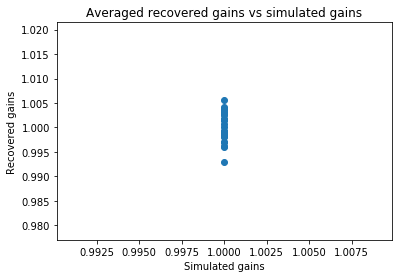

In [208]:
fig, ax = plt.subplots()

ax.scatter(sim_gains_amp_2, rec_gains_mean_amp_2)
#ax.plot(lims, lims,'g')
#plt.errorbar(x_true_real[:Ndish,time_channel],x_rec_real[:Ndish,time_channel],xerr=None,yerr=error[:Ndish],linestyle="None")
plt.xlabel('Simulated gains')
plt.ylabel('Recovered gains')
lim=.002
#plt.ylim(0.978,0.982)
plt.title('Averaged recovered gains vs simulated gains')
#plt.ylim(0.998,1.002)
#plt.savefig('avgd_recgains_vs_simgains_corrcal_5by5_nogainfluc_Tsys_50_no_dish_scatter_1e-4_initguess')


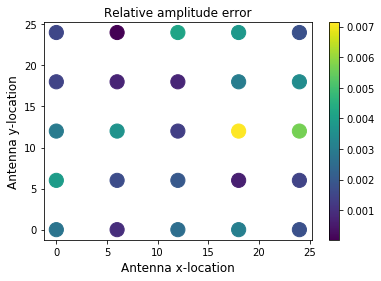

In [209]:
colour_scatterplot(m,rel_err_amp_2)

In [210]:
print rec_gains_mean_amp_2.min(), rec_gains_mean_amp_2.max()

0.9928620857726348 1.0056599842364684


In [211]:
def hist_rel_err_mean_std(gg,sim_gains_amp):
    gg_amp=gg[:,0::2]
    rel_error=np.abs((gg_amp-sim_gains_amp))/sim_gains_amp
    gg_amp_mean=np.mean(rel_error,axis=1) #shape is number of runs
    gg_amp_std=np.std(rel_error,axis=1,ddof=1)
    return gg_amp_std, gg_amp_mean

def hist_rel_err_mean_std_logcal(gg,sim_gains_amp):
    gg_amp=gg
    rel_error=np.abs((gg_amp-sim_gains_amp))/(sim_gains_amp) # remember to input exponent of both fit and simulated gains
    gg_amp_mean=np.mean(rel_error,axis=1) #shape is number of runs
    gg_amp_std=np.std(rel_error,axis=1,ddof=1)
    return gg_amp_std, gg_amp_mean


In [212]:
#np.save('std_fg_no_scatter_100runs_tsys_5',hist_rel_err_mean_std(gg_2,sim_gains_amp_2)[0])

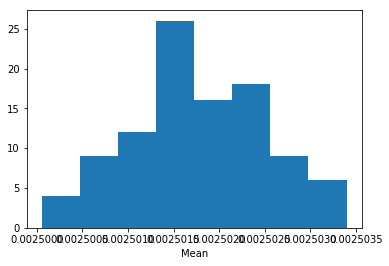

In [213]:
plt.hist(hist_rel_err_mean_std(gg_2,sim_gains_amp_2)[1],'auto') 
plt.xlabel('Mean')
#plt.savefig('std_hist_corrcal_5by5_nogainfluc_Tsys_50_no_dish_scatter_initguess_1e-4')
plt.show()

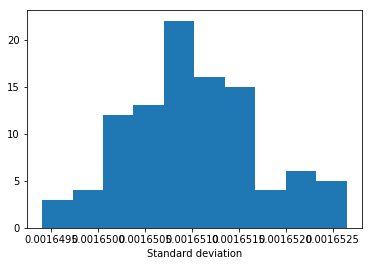

In [214]:
plt.hist(hist_rel_err_mean_std(gg_2,sim_gains_amp_2)[0],'auto') 
#plt.hist(std_fg, 'auto',color='b')
#plt.hist(std_no_sky_cov, 'auto', color='r')
plt.xlabel('Standard deviation')
#plt.xlim(0.0025,0.02)
#plt.savefig('std_hist_corrcal_5by5_nogainfluc_Tsys_50_no_dish_scatter_initguess_1e-4')
plt.show()